## Import libraries

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import opendatasets as od

In [47]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight 

## Download dataset

In [48]:
# Download dataset from Kaggle
od.download("https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset")

Skipping, found downloaded files in ".\face-expression-recognition-dataset" (use force=True to force download)


In [49]:
# Path to the dataset
folder_path = "C:\\Users\\Alia-\\Documents\\EC-sthlm\\Deep Learning\\Kunskapskontroll 2\\face-expression-recognition-dataset\\images\\"

## Visualizing images

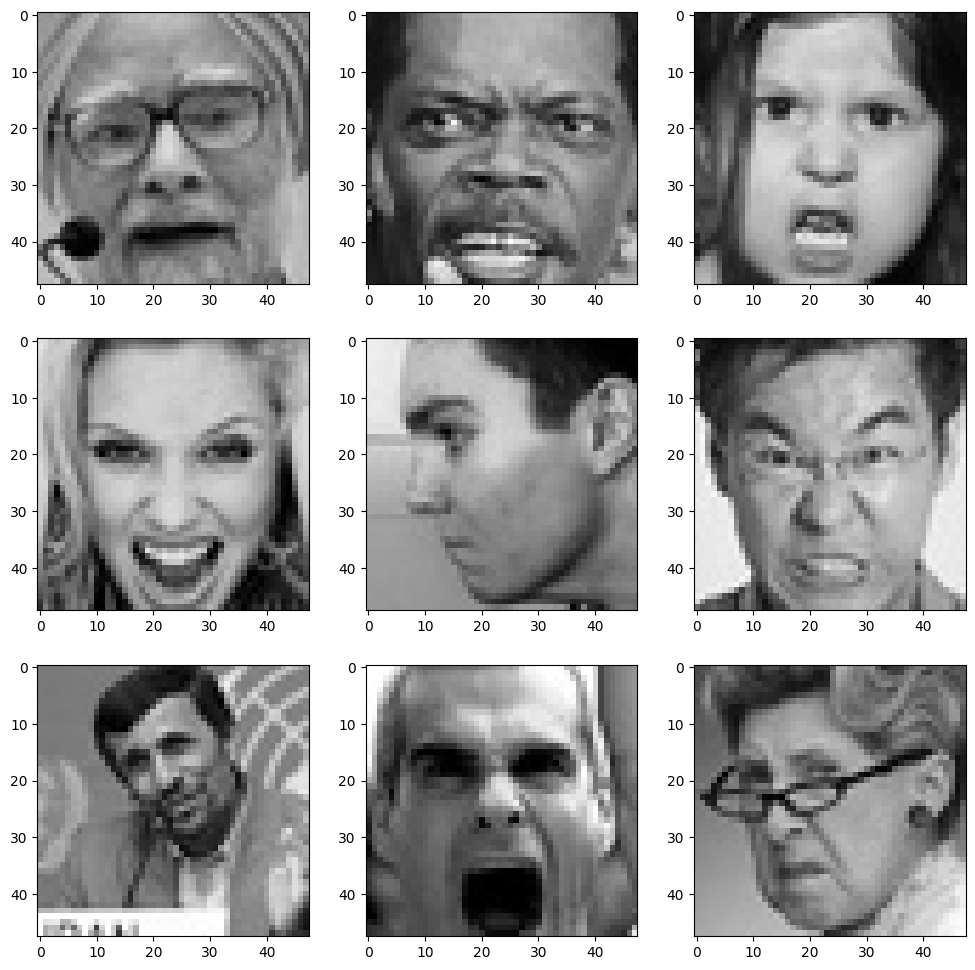

In [62]:
# Visualize sample images from the dataset to understand the data and check if the images are loaded correctly.
expression = 'angry'

plt.figure(figsize=(12,12))
for i in range(1,10,1):
    plt.subplot(3,3,i)
    img = load_img(folder_path + "train/" + expression + "/" + os.listdir(folder_path + "train/" + expression)[i], target_size=(48, 48))
    plt.imshow(img)
plt.show()

## Data Preparation

In [51]:
# Data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    folder_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Only for training
)

validation_generator = train_datagen.flow_from_directory(
    folder_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Only for validation
)

Found 57420 images belonging to 3 classes.
Found 14354 images belonging to 3 classes.


In [52]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

## Build the model

In [54]:
# Define the convolutional neural network (CNN) model architecture.
# The model is designed to classify facial expressions based on the input images.
model = Sequential([
    Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 3)),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(3, activation='softmax')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,095,299 (19.44 MB)

 Trainable params: 5,093,379 (19.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

## Train the Model

In [55]:
# Callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.00001)

callbacks = [checkpoint, early_stopping, reduce_lr]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/50


C:\Users\Alia-\anaconda30\envs\DL\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1794/1794 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.3283 - loss: 1.4611
Epoch 1: val_accuracy improved from -inf to 0.35379, saving model to best_model.keras
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 343s 190ms/step - accuracy: 0.3283 - loss: 1.4610 - val_accuracy: 0.3538 - val_loss: 1.0913 - learning_rate: 0.0010
Epoch 2/50
   1/1794 ━━━━━━━━━━━━━━━━━━━━ 5:00 168ms/step - accuracy: 0.3438 - loss: 1.2980
Epoch 2: val_accuracy improved from 0.35379 to 0.55556, saving model to best_model.keras


C:\Users\Alia-\anaconda30\envs\DL\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1794/1794 ━━━━━━━━━━━━━━━━━━━━ 1s 186us/step - accuracy: 0.3438 - loss: 1.2980 - val_accuracy: 0.5556 - val_loss: 1.0635 - learning_rate: 0.0010
Epoch 3/50
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.3274 - loss: 1.1404
Epoch 3: val_accuracy did not improve from 0.55556
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 342s 191ms/step - accuracy: 0.3274 - loss: 1.1404 - val_accuracy: 0.3628 - val_loss: 1.0898 - learning_rate: 0.0010
Epoch 4/50
   1/1794 ━━━━━━━━━━━━━━━━━━━━ 5:03 169ms/step - accuracy: 0.3438 - loss: 0.9252
Epoch 4: val_accuracy did not improve from 0.55556
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 0s 35us/step - accuracy: 0.3438 - loss: 0.9252 - val_accuracy: 0.4444 - val_loss: 1.0271 - learning_rate: 0.0010
Epoch 5/50
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.3173 - loss: 1.1428
Epoch 5: val_accuracy did not improve from 0.55556
1794/1794 ━━━━━━━━━━━━━━━━━━━━ 323s 180ms/step - accuracy: 0.3173 - loss: 1.1428 - val_accuracy: 0.3784 - val_loss: 1.1035 - learning_rate:

## Evaluate the model

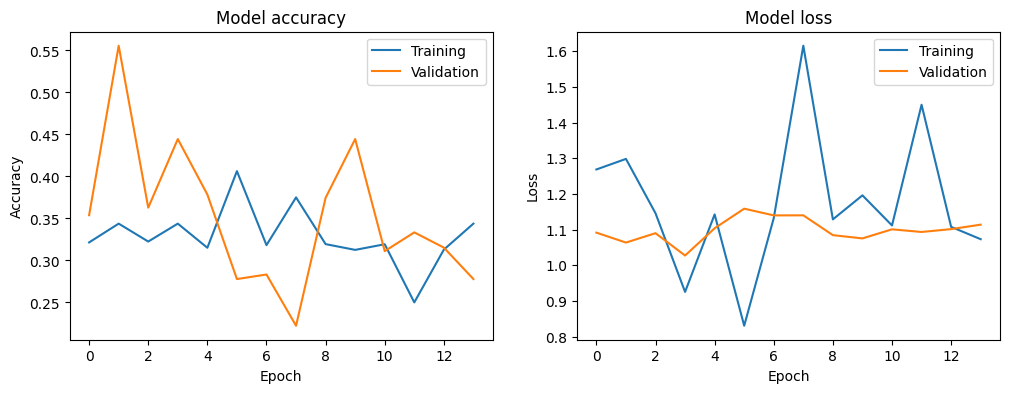

In [68]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [67]:
model.save('my_model.keras')
print("Model saved as 'my_model.keras'")

Model saved as 'my_model.keras'


## Conclusion 

Training loss: Starts at 1.4611 (Epoch 1), Ends at 1.0729 (Epoch 14) 

Validation oss: Starts at 1.0913 (Epoch 1), Ends at 1.1137 (Epoch 14)

Training accuracy: Starts at 0.3283 (Epoch 1), Ends at 0.3438 (Epoch 14)

Validation accuracy: Starts at 0.3538 (Epoch 1), Ends at 0.2778 (Epoch 14)

The training loss decreased from 1.4611 to 1.0729, and the training accuracy showed a slight increase from 0.3283 to 0.3438 over 14 epochs. This indicates that the model was learning to some extent but struggled to achieve significant improvements.

The validation metrics did not improve consistently, suggesting that the model had difficulties generalizing beyond the training data.

The best validation accuracy achieved was 0.5556 at Epoch 2.

## Reflektion

1.	Utmaningar du haft under arbetet samt hur du hanterat dem. 
En av de största utmaningarna jag hade var att komma igång med uppgiften. Det var svårt att veta var jag skulle börja och hur jag skulle strukturera koden. Men när jag väl hade börjat och fått en klar idé om vad som behövde göras, blev arbetet mycket enklare. Jag hanterade denna utmaning genom att bryta ner uppgiften i mindre, hanterbara delar och fokusera på en del i taget. Genom att ta små steg och lösa problem ett i taget kunde jag göra kontinuerliga framsteg och hålla motivationen uppe.

2.	Vilket betyg du anser att du skall ha och varför. 
Jag anser att jag förtjänar betyget G. Jag har genomfört alla delar av uppgiften och uppnått de mål som sattes upp från början. Trots initiala svårigheter lyckades jag fullfölja uppgiften och presentera en fungerande kod. Jag har också visat förmåga att lösa problem och hantera utmaningar effektivt. Även om det finns utrymme för förbättringar i kodens effektivitet och struktur, har jag visat grundläggande förståelse och genomförande av uppgiften.

3.	Tips du hade ”gett till dig själv” i början av kursen nu när du slutfört den. 
Ett tips jag skulle ge till mig själv i början av kursen är att inte bli överväldigad av omfattningen av uppgifterna. Det är viktigt att börja med små steg och inte försöka förstå allt på en gång. Det är bättre att ställa frågor och få klarhet tidigt än att kämpa ensam med probmen. 

